In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder, PowerTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
# from sklearn.feature_selection import SelectKBest, chi2, f_classif, RFE, MutualInfoClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer

In [3]:

# Load Data (Assuming data is in ../SentinelNet/data or ../data relative to notebook)
# You might need to adjust the path based on your exact folder structure
train_path = './data/KDDTrain+.txt'
test_path = './data/KDDTest+.txt'

# Try loading with error handling for paths
try:
    df_train = pd.read_csv(train_path, header=None, names=COL_NAMES)
    df_test = pd.read_csv(test_path, header=None, names=COL_NAMES)
    print(f"Training Data Shape: {df_train.head()}")
    print(f"Test Data Shape: {df_test.tail()}")
except FileNotFoundError:
    print("Files not found. Please check the paths. Trying absolute paths or checking local directory...")
    # Fallback to local directory if paths are different
    if os.path.exists('KDDTrain+.txt'):
        df_train = pd.read_csv('KDDTrain+.txt', header=None, names=COL_NAMES)
        df_test = pd.read_csv('KDDTest+.txt', header=None, names=COL_NAMES)

# Combine for initial analysis (optional, but good for understanding full global distributions)
# We will split back later to avoid data leakage.
# For rigorous preprocessing, we fit on TRAIN and transform TEST.


NameError: name 'COL_NAMES' is not defined

In [2]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Plot styling
plt.style.use('ggplot')
sns.set_palette("husl")

# Define Column Names for NSL-KDD (Standard List)
COL_NAMES = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label", "difficulty_level"]

In [4]:

# Mapping Dictionary
attack_mapping = {
    'normal': 'normal',
    
    # DoS
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS', 'smurf': 'DoS', 'teardrop': 'DoS', 'mailbomb': 'DoS', 'apache2': 'DoS', 'processtable': 'DoS', 'udpstorm': 'DoS',
    
    # Probe
    'satan': 'Probe', 'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'mscan': 'Probe', 'saint': 'Probe',
    
    # R2L
    'guess_passwd': 'R2L', 'ftp_write': 'R2L', 'imap': 'R2L', 'phf': 'R2L', 'multihop': 'R2L', 'warezmaster': 'R2L', 'warezclient': 'R2L', 'spy': 'R2L', 'xlock': 'R2L', 'xsnoop': 'R2L', 'snmpguess': 'R2L', 'snmpgetattack': 'R2L', 'httptunnel': 'R2L', 'sendmail': 'R2L', 'named': 'R2L',
    
    # U2R
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R', 'ps': 'U2R', 'xterm': 'U2R', 'sqlattack': 'U2R'
}

# Apply mapping
df_train['attack_class'] = df_train['label'].map(lambda x: attack_mapping.get(x, 'other'))
df_test['attack_class'] = df_test['label'].map(lambda x: attack_mapping.get(x, 'other'))

print("Training Class Distribution:")
print(df_train['attack_class'].value_counts())


NameError: name 'df_train' is not defined

In [5]:
#Definign feature Groups

categorical_features = ['protocol_type','service','flag']
binary_features = ['land','logged_in','is_host_login','is_guest_login']
#All the other numerical values

numerical_features = [col for col in COL_NAMES if col not in categorical_features + binary_features +['label','difficulty_level']]

print(f"Categorical Features: {len(categorical_features)}")
print(f"Binary Features: {len(binary_features)}")
print(f"Numerical Features: {len(numerical_features)}")

print(df_train.isnull())


NameError: name 'COL_NAMES' is not defined

In [6]:
def clean_outliers_isolation_forest(df,contamination = 0.01):
    iso_df  = df[numerical_features].copy()

    clf = IsolationForest(max_samples='auto',contamination = contamination, random_state = 42)

    outliers = clf.fit_predict(iso_df)

    n_outliers = (outliers == -1).sum()
    print(f"Identifies {n_outliers} Outlilers using the Isolation forest")

    return outliers
df_train['is_outlier'] = clean_outliers_isolation_forest(df_train)


Identifies 1256 Outlilers using the Isolation forest


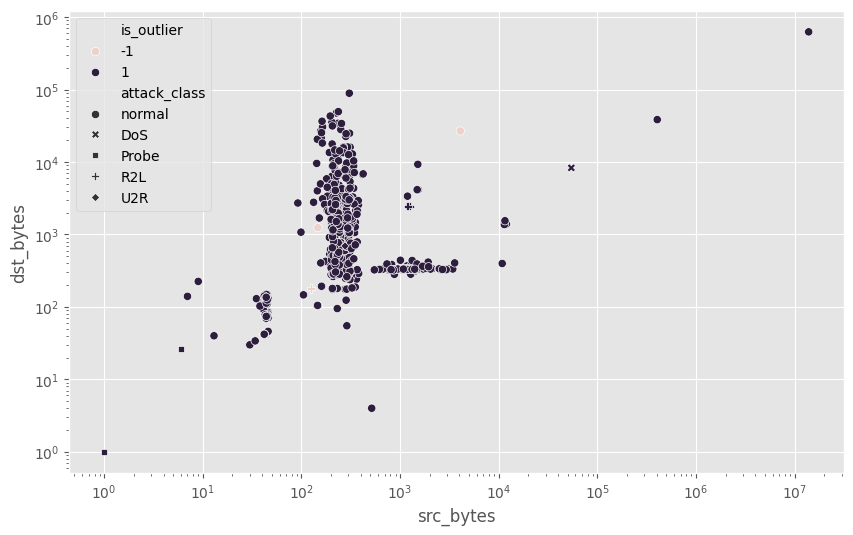

In [7]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_train[::100], x = 'src_bytes', y = 'dst_bytes', hue='is_outlier', style='attack_class')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [6]:
skewed_cols = ['duration','src_bytes','dst_bytes']

#Function for the Log1p transformation (log(x+1)) to  handle the zeros

def apply_log_transform(df,cols):
    df_transform = df.copy()
    for col in cols:
        #Creating a new column Name
        new_col = f"log_{col}"
        #applying the logarithimic operation

        df_transform[new_col] = np.log1p(df_transform[col])

        plt.figure(figsize = (12,4))
        plt.subplot(1,2,1)
        sns.histplot(df[col],bins = 30, kde=True)
        plt.title(f"Original {col}")

        plt.subplot(1,2,2)
        sns.histplot(df_transform[new_col],bins = 30, kde=True)
        plt.title(f"Transformed {col}")
        plt.show()
    return df_transformed

df_train = apply_log_transform(df_train,skewed_cols)
df_test = apply_log_transform(df_test,skewed_cols)


NameError: name 'df_train' is not defined

In [9]:

def engineer_features(df):
    df_eng = df.copy()
    
    # 1. Total Bytes
    df_eng['total_bytes'] = df_eng['src_bytes'] + df_eng['dst_bytes']
    
    # 2. Byte Ratio (Handle division by zero)
    df_eng['src_bytes_ratio'] = df_eng['src_bytes'] / (df_eng['total_bytes'] + 1e-5)
    
    # 3. Load / Packet Rate
    # If duration is 0, we assume it's a single instantaneous event (rate = count)
    df_eng['packet_rate'] = df_eng['count'] / (df_eng['duration'] + 1e-5)
    
    # 4. Title: Flow Asymmetry
    df_eng['byte_diff'] = abs(df_eng['src_bytes'] - df_eng['dst_bytes'])
    
    # 5. Flag interactions (example: is it an error flag?)
    error_flags = ['S0', 'S1', 'S2', 'S3', 'REJ']
    df_eng['is_error_flag'] = df_eng['flag'].isin(error_flags).astype(int)
    
    # 6. Critical Host Interaction
    # Interaction between 'same_srv_rate' and 'dst_host_same_srv_rate'
    df_eng['same_srv_interaction'] = df_eng['same_srv_rate'] * df_eng['dst_host_same_srv_rate']
    
    return df_eng

df_train = engineer_features(df_train)
df_test = engineer_features(df_test)

print("New Feature Set Head:")
print(df_train[['src_bytes_ratio', 'packet_rate', 'is_error_flag', 'same_srv_interaction']].head())


New Feature Set Head:
   src_bytes_ratio  packet_rate  is_error_flag  same_srv_interaction
0         1.000000     200000.0              0                 0.170
1         1.000000    1300000.0              0                 0.000
2         0.000000   12300000.0              1                 0.005
3         0.027668     500000.0              0                 1.000
4         0.321486    3000000.0              0                 1.000


In [18]:
df_train['service']

0         ftp_data
1            other
2          private
3             http
4             http
            ...   
125968     private
125969     private
125970        smtp
125971      klogin
125972    ftp_data
Name: service, Length: 125973, dtype: object

In [34]:
ohe = OneHotEncoder(sparse_output=False,handle_unknown='ignore')
cols_to_encode = ['protocol_type','flag']

#Fit and Train

ohe_train = pd.DataFrame(ohe.fit_transform(df_train[cols_to_encode]))
ohe_train.columns = ohe.get_feature_names_out(cols_to_encode)
ohe_train.index = df_train.index
# ohe_train.index

#Transform Test

ohe_test = pd.DataFrame(ohe.transform(df_test[cols_to_encode]))
ohe_test.columns = ohe.get_feature_names_out(cols_to_encode)
ohe_test.index = df_test.index

service_freq = df_train['service'].value_counts(normalize = True)
df_train['service_freq'] = df_train['service'].map(service_freq)
df_test['service_freq'] = df_test['service'].map(service_freq).fillna(0)

df_train_encode = pd.concat([df_train,ohe_train],axis = 1)
df_test_encode = pd.concat([df_test,ohe_test],axis = 1)

df_train_encode.columns
# df_train_encode

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label', 'difficulty_level', 'attack_class',
       'is_outlier', 'total_bytes', 'src_bytes_ratio', 'packet_rate',
       'byte_diff', 'is_error_flag', 'same_srv_interaction', 'serv

In [35]:
print(df_train_encode.columns)

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label', 'difficulty_level', 'attack_class',
       'is_outlier', 'total_bytes', 'src_bytes_ratio', 'packet_rate',
       'byte_diff', 'is_error_flag', 'same_srv_interaction', 'serv

In [28]:
df_test_encode

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,tcp,private,REJ,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,tcp,private,REJ,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,tcp,smtp,SF,794,333,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22540,0,tcp,http,SF,317,938,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22541,0,tcp,http,SF,54540,8314,0,0,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22542,0,udp,domain_u,SF,42,42,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [36]:
df_train_encode.drop(columns=['protocol_type','flag','service'],inplace = True)
df_test_encode.drop(columns=['protocol_type','flag','service'],inplace = True)

In [38]:
print(df_train_encode.shape)

df_test_encode

(125973, 63)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,12983,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,20,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,0,15,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,794,333,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22540,0,317,938,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22541,0,54540,8314,0,0,0,2,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22542,0,42,42,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
